# Artificial Intelligence: Homework 2 - Machine Learning

Alexandru Sima (332CA)


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

%matplotlib inline

## Air pollution


In [138]:
raw_train_data = pd.read_csv("datasets/air_pollution_test.csv")

##### Split data by type


In [139]:
def split_data(
    data: pd.DataFrame,
    numeric_columns: list[str],
    categorical_columns: list[str],
    label_column: str,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [attr for attr in numeric_columns if attr in data.columns]
    categorical_attrs = [attr for attr in categorical_columns if attr in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[label_column]

    return numeric_attrs, categorical_attrs, labels

In [140]:
numeric_columns = [
    "AQI_Value",
    "CO_Value",
    "Ozone_Value",
    "NO2_Value",
    "PM25_Value",
    "VOCs",
    "SO2",
]
categorical_columns = [
    "Country",
    "City",
    "CO_Category",
    "Ozone_Category",
    "NO2_Category",
    "PM25_Category",
    "Emissions",
]
label_columns = "AQI_Category"

num_train_data, cat_train_data, train_labels = split_data(
    raw_train_data, numeric_columns, categorical_columns, label_columns
)

### Exploratory data analysis


In [141]:
def print_numerical_info(data: pd.DataFrame):
    print(data.describe())
    data.boxplot()

         AQI_Value     CO_Value  Ozone_Value    NO2_Value   PM25_Value  \
count  4693.000000  4693.000000  4217.000000  4693.000000  4693.000000   
mean     72.127424     1.327935    34.706189    42.887032    68.634775   
std      55.838493     1.356232    27.023739   195.686936    55.118326   
min       6.000000     0.000000     0.000000     0.000000     2.000000   
25%      39.000000     1.000000    21.000000     0.000000    35.000000   
50%      55.000000     1.000000    30.000000     1.000000    54.000000   
75%      80.000000     1.000000    40.000000     4.000000    80.000000   
max     500.000000    21.000000   207.000000  1003.063334   500.000000   

              VOCs          SO2  
count  4693.000000  4693.000000  
mean    185.239825     4.393056  
std     139.841721     5.431688  
min      15.461284   -13.338278  
25%     103.767142     0.741786  
50%     143.413477     4.288641  
75%     205.616347     7.814964  
max    1279.853139    41.595139  


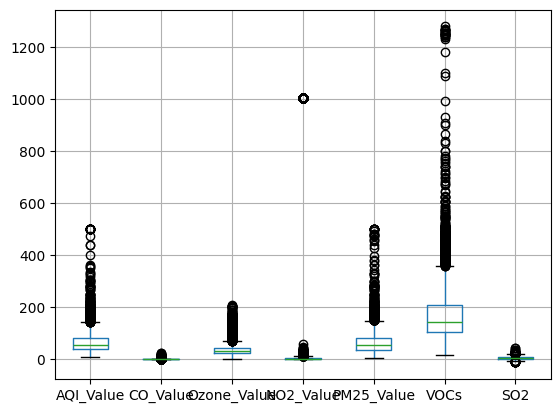

In [142]:
print_numerical_info(num_train_data)

#### Atribute corellation


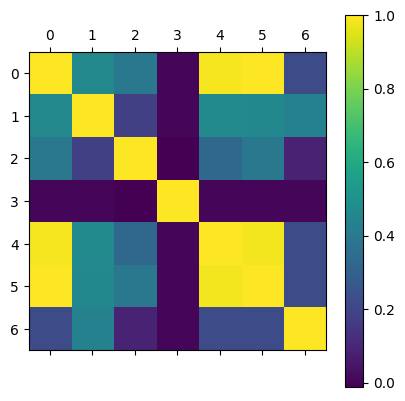

In [143]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

Chi2 test for Country and Country:
  statistic: 678405.0
  p-value: 0.0

Chi2 test for Country and City:
  statistic: 678258.0
  p-value: 0.4495532124080549

Chi2 test for Country and CO_Category:
  statistic: 0.0
  p-value: 1.0

Chi2 test for Country and Ozone_Category:
  statistic: 1820.1211447312326
  p-value: 5.8229909502570764e-126

Chi2 test for Country and NO2_Category:
  statistic: 64.94264350733792
  p-value: 0.9999999995488775

Chi2 test for Country and PM25_Category:
  statistic: 3617.990368089555
  p-value: 0.0

Chi2 test for Country and Emissions:
  statistic: 3617.990368089555
  p-value: 0.0

Chi2 test for City and Country:
  statistic: 678258.0000000001
  p-value: 0.4495532124080153

Chi2 test for City and City:
  statistic: 22010171.999999203
  p-value: 0.23973444887666215

Chi2 test for City and CO_Category:
  statistic: 0.0
  p-value: 1.0

Chi2 test for City and Ozone_Category:
  statistic: 18768.0
  p-value: 0.4903911868634493

Chi2 test for City and NO2_Category:
  

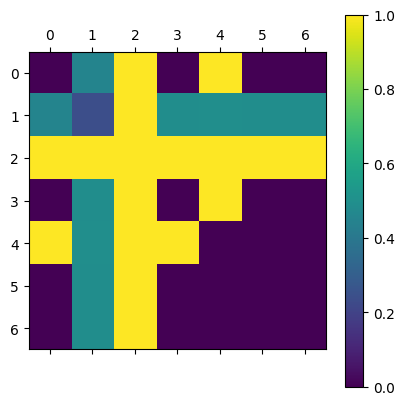

In [144]:
pvalues = np.zeros((len(cat_train_data.columns), len(cat_train_data.columns)))

for i, row in enumerate(cat_train_data.columns):
    for j, col in enumerate(cat_train_data.columns):
        observed = pd.crosstab(cat_train_data[row], cat_train_data[col])
        statistic = sp.stats.chi2_contingency(observed)
        pvalues[i, j] = statistic.pvalue
        print(f"Chi2 test for {row} and {col}:")
        print(f"  statistic: {statistic[0]}")
        print(f"  p-value: {statistic[1]}")
        print()

plt.matshow(pvalues)
plt.colorbar()
plt.show()

### Preprocessing


#### Imputing missing data


In [145]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)

In [146]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)

In [147]:
num_train_data = impute_missing_numerical_data(num_train_data)
cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


In [148]:
def remove_extreme_values(data: pd.DataFrame):
    for col in data.columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data[col].clip(lower_bound, upper_bound, inplace=True)

In [149]:
remove_extreme_values(num_train_data)

/tmp/ipykernel_201386/3195783679.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].clip(lower_bound, upper_bound, inplace=True)
/tmp/ipykernel_201386/3195783679.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [150]:
# TODO
def remove_redundant_attributes(num_data: pd.DataFrame, cat_data):
    del num_data["PM25_Value"]
    del num_data["VOCs"]

    del cat_data["City"]


remove_redundant_attributes(num_train_data, cat_train_data)

#### Domain standardization


In [151]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

In [152]:
num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [153]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])

In [154]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)

In [155]:
encode_categorical_attributes(cat_train_data)
train_labels = encode_labels(train_labels)

### Prediction


#### Train data


          AQI_Value  CO_Value   Ozone_Value     NO2_Value           SO2
count  4.693000e+03    4693.0  4.693000e+03  4.693000e+03  4.693000e+03
mean  -4.466442e-17       0.0 -2.501964e-16 -6.737514e-17  4.542144e-18
std    1.000107e+00       0.0  1.000107e+00  1.000107e+00  1.000107e+00
min   -1.653009e+00       0.0 -2.209867e+00 -8.219134e-01 -2.713505e+00
25%   -7.473037e-01       0.0 -6.711895e-01 -8.219134e-01 -6.888490e-01
50%   -3.081739e-01       0.0  2.820924e-02 -5.258631e-01 -1.200468e-02
75%    3.779663e-01       0.0  5.177884e-01  3.622879e-01  6.609214e-01
max    2.065871e+00       0.0  2.301255e+00  2.138590e+00  2.685577e+00


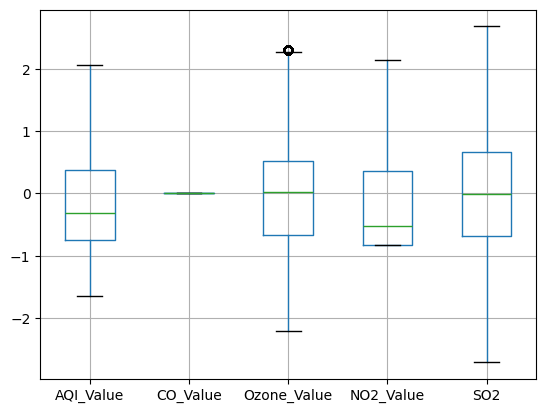

In [156]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print_numerical_info(train_data)

#### Test data


In [157]:
raw_test_data = pd.read_csv("datasets/air_pollution_test.csv")

In [158]:
num_test_data, cat_test_data, test_labels = split_data(
    raw_test_data, numeric_columns, categorical_columns, label_columns
)

In [159]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
remove_redundant_attributes(num_test_data, cat_test_data)
encode_categorical_attributes(cat_test_data)

In [160]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)
print(test_data)

      AQI_Value  CO_Value   Ozone_Value  NO2_Value       SO2 Country  \
0     -0.575425 -0.241824 -1.276908e+00  -0.219185 -0.798404      18   
1     -0.002282  0.495591 -1.042657e+00  -0.173188  0.547675      86   
2     -0.127657 -0.979240 -2.774085e-16  -0.219185 -1.202303     139   
3      1.645502  1.970421 -5.741557e-01  -0.183410  1.750672     121   
4     -0.109746 -0.241824  8.955444e-02  -0.208963 -1.511211      53   
...         ...       ...           ...        ...       ...     ...   
4688  -0.163479 -0.241824 -8.084063e-01  -0.178299 -0.245906     144   
4689  -0.521693 -0.241824 -3.399051e-01  -0.198742  0.550590      53   
4690   0.069361 -0.241824  1.147089e-02  -0.208963 -0.224710     118   
4691   0.176825  0.495591 -9.255317e-01  -0.127191  0.578894      70   
4692  -0.360496 -0.241824  1.285962e-01  -0.208963  0.587153     141   

     CO_Category Ozone_Category NO2_Category PM25_Category Emissions  
0              0              0            0             0      

#### Classifiers


In [161]:
classifiers = [
    "Decision Tree",
    "Random Forest",
    "Logistic Regression",
    "Multi-Layer Perceptron",
]
scores = []

##### Decision Tree


In [162]:
def run_classifier(
    classifier, test_data: pd.DataFrame, test_labels: pd.Series
) -> float:
    predicted_labels = classifier.predict(test_data)

    sk.metrics.ConfusionMatrixDisplay.from_predictions(
        test_labels,
        predicted_labels,
    )
    plt.show()

    return classifier.score(test_data, test_labels)

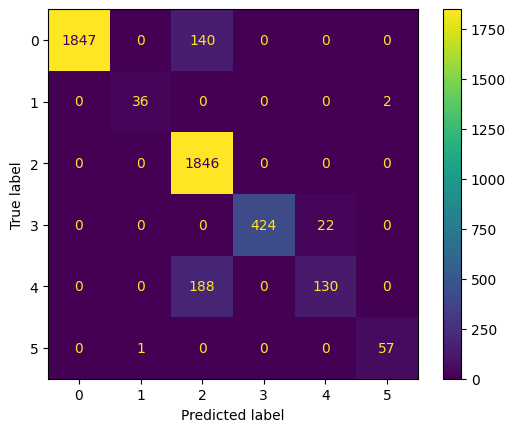

In [163]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

##### Random forest


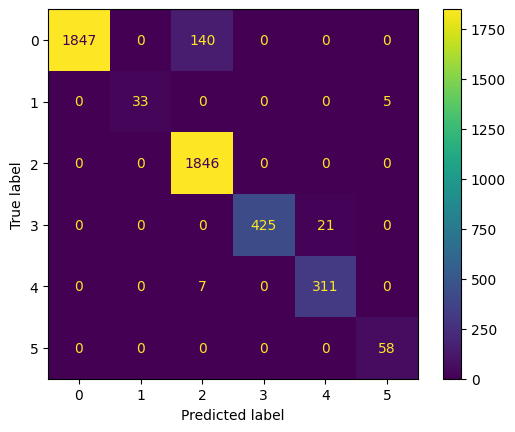

In [164]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

##### Logistic regression


In [165]:
class MultiClassLogisticRegression:
    class LogisticRegression:
        @staticmethod
        def sigmoid(
            x: np.ndarray,
        ) -> np.ndarray:  # multe probleme daca nu sunt scalate datele
            return 1 / (1 + np.exp(-x))

        def __init__(self, max_iter: int, lr: float):
            self.max_iter = max_iter
            self.lr = lr

        def predict(self, X: np.ndarray) -> np.ndarray:
            return self.sigmoid(X @ self.w)

        def fit(self, X: np.ndarray, t: np.ndarray):
            n, d = X.shape
            self.w = np.random.randn(d)

            for _ in range(self.max_iter):
                y = self.predict(X)
                self.w -= self.lr * (1 / n) * (X.T @ (y - t))

        def accuracy(self, X, t):
            y = self.predict(X)
            n, _ = y.shape

            return (np.sum(y[t == 1] >= 0.5) + np.sum(y[t == 0] < 0.5)) / n

    def __init__(self, max_iter: int = 1000, learning_rate: float = 0.01):
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    def fit(self, data: pd.DataFrame, labels: np.ndarray):
        self.predictors = []
        X = data.to_numpy(dtype=np.float64)

        for target in np.unique(labels):
            target_labels = labels == target

            predictor = self.LogisticRegression(self.max_iter, self.learning_rate)
            predictor.fit(X, target_labels)

            self.predictors.append(predictor)

    def predict(self, data: pd.DataFrame) -> np.ndarray:
        X = data.to_numpy(dtype=np.float64)

        y = self.predictors[0].predict(X)
        classes = np.zeros_like(y, dtype=int)

        for i, predictor in enumerate(self.predictors[1:]):
            yy = predictor.predict(X)
            improv = yy > y

            y[improv] = yy[improv]
            classes[improv] = i + 1

        return classes

    def score(self, data: pd.DataFrame, labels: pd.Series) -> float:
        Y = self.predict(data)
        return sk.metrics.accuracy_score(labels, Y)

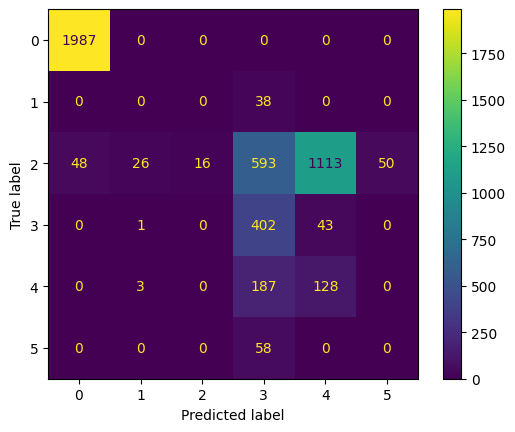

In [166]:
classifier = MultiClassLogisticRegression(max_iter=10000)
classifier.fit(train_data, train_labels)

run_classifier(
    classifier,
    train_data,
    train_labels,
)
scores.append(classifier.score(train_data, train_labels))

##### Multi-layered perceptron


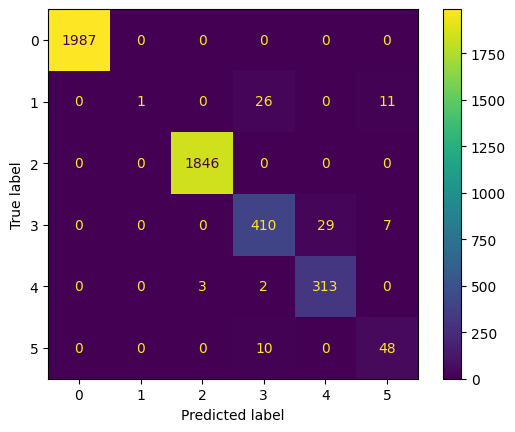

In [175]:
classifier = sk.neural_network.MLPClassifier(hidden_layer_sizes=[100, 100, 1000, 100, 100])
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

#### Classifier comparison


<Axes: >

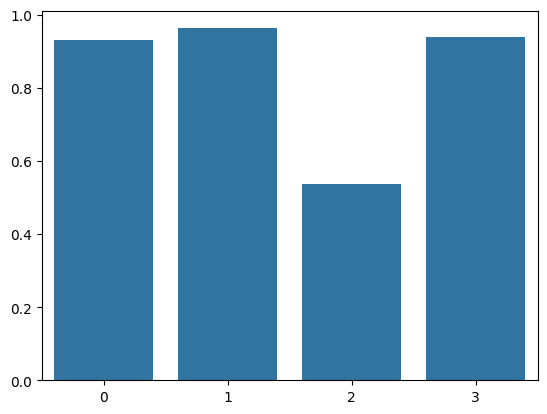

In [119]:
sns.barplot(scores)

## News popularity


In [120]:
raw_train_data = pd.read_csv("datasets/news_popularity_train.csv")

In [121]:
numeric_columns = [
    " days_since_published",
    " title_word_count",
    " content_word_count",
    " unique_word_ratio",
    " non_stop_word_ratio",
    " unique_non_stop_ratio",
    " external_links",
    " internal_links",
    " image_count",
    " video_count",
    " avg_word_length",
    " keyword_count",
    " keyword_worst_min_shares",
    " keywords_worst_max_shares",
    " keyword_worst_avg_shares",
    " keyword_best_min_shares",
    " keyword_best_max_shares",
    " keyword_best_avg_shares",
    " keyword_avg_min_shares",
    " keyword_avg_max_shares",
    " keyword_avg_avg_shares",
    " ref_min_shares",
    " ref_max_shares",
    " ref_avg_shares",
    " topic_0_relevance",
    " topic_1_relevance",
    " topic_2_relevance",
    " topic_3_relevance",
    " topic_4_relevance",
    " content_subjectivity",
    " content_sentiment",
    " positive_word_rate",
    " negative_word_rate",
    " non_neutral_positive_rate",
    " non_neutral_negative_rate",
    " avg_positive_sentiment",
    " min_positive_sentiment",
    " max_positive_sentiment",
    " avg_negative_sentiment",
    " min_negative_sentiment",
    " max_negative_sentiment",
    " title_subjectivity",
    " title_sentiment",
    " title_subjectivity_magnitude",
    " title_sentiment_magnitude",
    " engagement_ratio",
    " content_density",
]
categorical_columns = [
    "url",
    " channel_lifestyle",
    " channel_entertainment",
    " channel_business",
    " channel_social_media",
    " channel_tech",
    " channel_world",
    " day_monday",
    " day_tuesday",
    " day_wednesday",
    " day_thursday",
    " day_friday",
    " day_saturday",
    " day_sunday",
    " is_weekend",
    " publication_period",
]
label_columns = "popularity_category"

num_train_data, cat_train_data, train_labels = split_data(
    raw_train_data, numeric_columns, categorical_columns, label_columns
)

### Exploratory data analysis


       days_since_published  title_word_count  content_word_count  \
count           31715.00000      31715.000000        31715.000000   
mean              354.83790         10.399464          546.247769   
std               214.00434          2.116433          470.782901   
min                 8.00000          2.000000            0.000000   
25%               164.00000          9.000000          246.000000   
50%               339.00000         10.000000          409.000000   
75%               542.00000         12.000000          716.000000   
max               731.00000         23.000000         8474.000000   

       unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
count       31715.000000         31715.000000           31715.000000   
mean            0.552400             1.002396               0.692922   
std             3.935710             5.848149               3.649410   
min             0.000000             0.000000               0.000000   
25%             0.

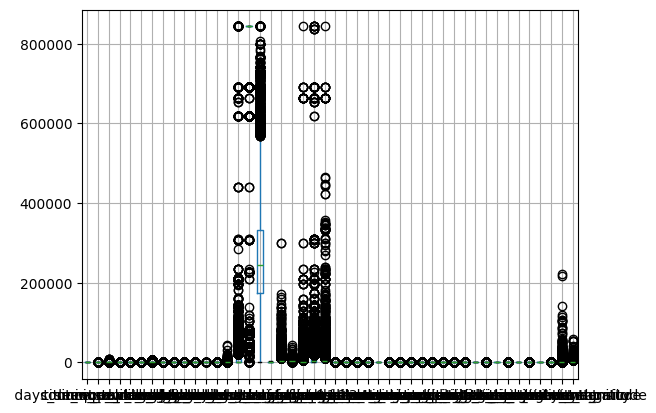

In [122]:
print(num_train_data.describe())
num_train_data.boxplot()
plt.show()

#### Atribute corellation


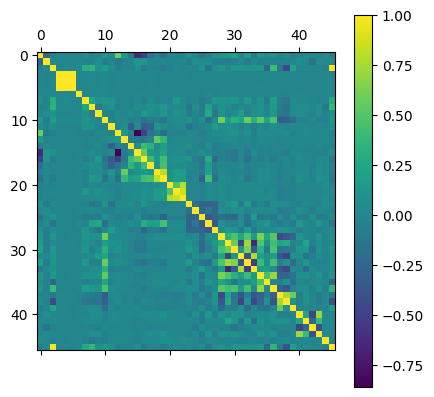

In [123]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

### Preprocessing


#### Imputing missing data


In [124]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


num_train_data = impute_missing_numerical_data(num_train_data)

In [125]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [126]:
def remove_redundant_attributes(num_data: pd.DataFrame, cat_data: pd.DataFrame):
    # del num_data["PM25_Value"]
    # del num_data["VOCs"]

    del cat_data["url"]


remove_redundant_attributes(num_train_data, cat_train_data)

#### Domain standardization


In [127]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)


num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [128]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])


encode_categorical_attributes(cat_train_data)

In [129]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)


train_labels = encode_labels(train_labels)

### Prediction


       days_since_published  title_word_count  content_word_count  \
count          3.171500e+04      3.171500e+04        3.171500e+04   
mean           7.527743e-17      3.127598e-16        2.240400e-17   
std            1.000016e+00      1.000016e+00        1.000016e+00   
min           -1.620731e+00     -3.968751e+00       -1.160315e+00   
25%           -8.917619e-01     -6.612474e-01       -6.377727e-01   
50%           -7.400854e-02     -1.887469e-01       -2.915355e-01   
75%            8.745853e-01      7.562541e-01        3.605800e-01   
max            1.757759e+00      5.953760e+00        1.683977e+01   

       unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
count       3.171500e+04         3.171500e+04           3.171500e+04   
mean       -1.433856e-17        -1.613088e-17           3.584639e-18   
std         1.000016e+00         1.000016e+00           1.000016e+00   
min        -1.403580e-01        -1.714067e-01          -1.898753e-01   
25%        -2.0750

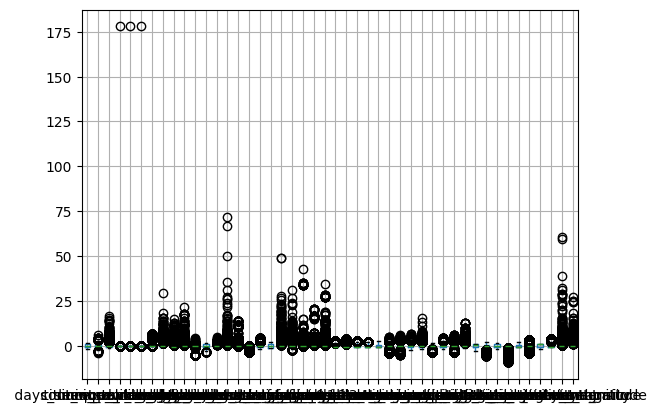

In [130]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print_numerical_info(train_data)

#### Test data


In [131]:
raw_test_data = pd.read_csv("datasets/news_popularity_test.csv")

In [132]:
num_test_data, cat_test_data, test_labels = split_data(
    raw_test_data, numeric_columns, categorical_columns, label_columns
)

In [133]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
remove_redundant_attributes(num_test_data, cat_test_data)
encode_categorical_attributes(cat_test_data)

In [134]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)

#### Decision Tree


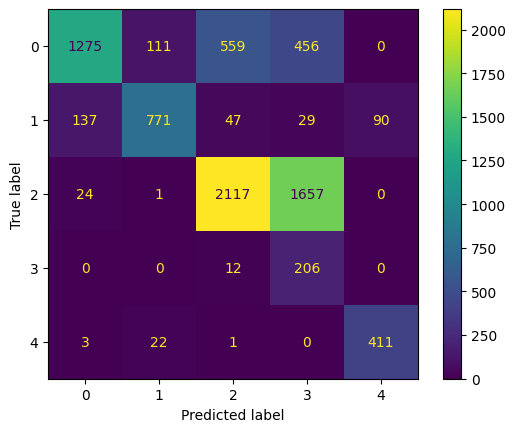

0.6028502963803758

In [135]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Random forest


In [136]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

KeyboardInterrupt: 

#### Logistic regression


/tmp/ipykernel_201386/2931805461.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


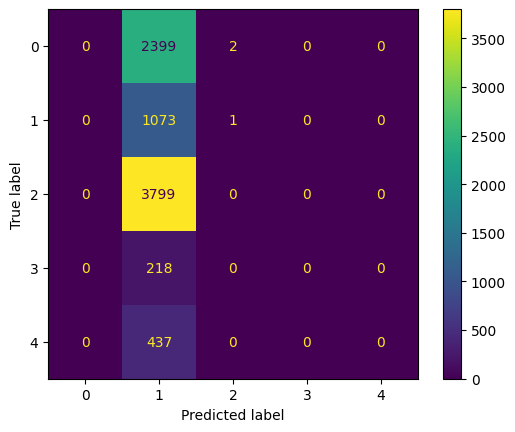

/tmp/ipykernel_201386/2931805461.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.1353260184134191

In [ ]:
classifier = MultiClassLogisticRegression(max_iter=10000)
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Multi-layered perceptron


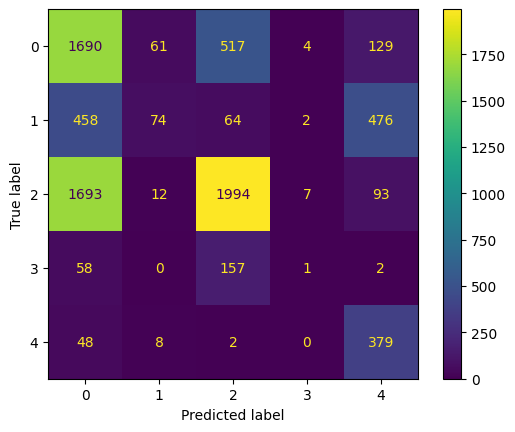

0.5218817000882835

In [ ]:
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)